In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from numpy import array
#given that stock data never goes below zero, MinMaxScaler was a no brainer choice
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.metrics import r2_score

# Collect the Stock Data

In [2]:
#install pyspark - AF
!pip install pyspark

#import SparkSession from pyspark - AF
from pyspark.sql import SparkSession

#create a SparkSession - AF
spark = SparkSession.builder.appName('Stocks').getOrCreate()

#WB if this fails to run in colab, please remember to upload "stock_details_5_years.csv",
#then paste the filepath below
file_path = "Resources/stock_details_5_years.csv"

#input the stock (company) symbol - AF
symbol_input = input("Enter the stock symbol: ")

#create a dataframe from the 5-year stock csv - AF
stock_df = spark.read.csv(file_path, header=True, inferSchema=True)

#(WB)taking string from "symbol_input" to autoname future graphs
graph_label=symbol_input

#create a dataframe for selected stock - AF
filtered_df = stock_df.filter(stock_df['Company'] == symbol_input)

#convert the filtered dataframe into a Pandas dataframe - AF
df = filtered_df.toPandas()

#display the filtered Pandas dataframe - AF
df.head()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
23/12/13 13:23:22 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits,Company
0,2018-11-28 21:00:00,35.075914,35.914412,35.028895,35.663647,26065315,0.0,0.0,PFE
1,2018-11-29 21:00:00,35.538260,36.251375,35.483405,36.227867,45054495,0.0,0.0,PFE
2,2018-12-02 21:00:00,36.337568,36.345404,35.859546,36.039783,26771178,0.0,0.0,PFE
3,2018-12-03 21:00:00,36.227868,36.415942,35.350187,35.373695,28703898,0.0,0.0,PFE
4,2018-12-05 21:00:00,34.934854,35.256146,34.182555,35.248310,32188528,0.0,0.0,PFE


In [3]:
# Separate features data
df2 = df.reset_index()['Close']
df2.head()

0    35.663647
1    36.227867
2    36.039783
3    35.373695
4    35.248310
Name: Close, dtype: float64

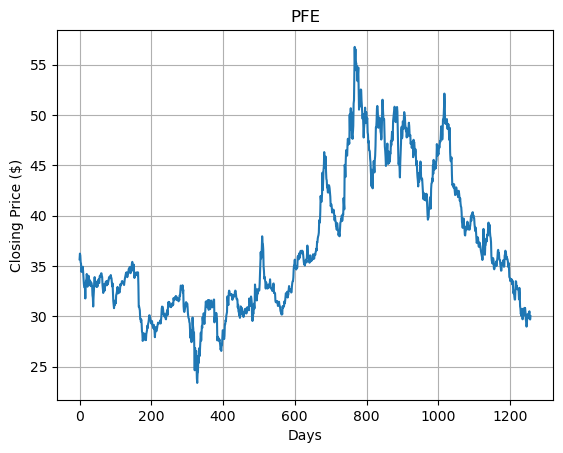

In [4]:
plt.plot(df2)
#(WB)added autoname + grid to graph
plt.title(graph_label)
# Add labels for x and y axis - SK
plt.xlabel('Days')
plt.ylabel('Closing Price ($)')
plt.grid()
plt.show()

# Preprocessing

In [5]:
# Rescale the data - SK
scaler = MinMaxScaler(feature_range=(0,1))
df2 = scaler.fit_transform(np.array(df2).reshape(-1, 1))
print(df2)

[[0.36790277]
 [0.38481733]
 [0.37917884]
 ...
 [0.20231139]
 [0.18882104]
 [0.19853707]]


In [6]:
# Split training/test datasets - AA
train_data, test_data = train_test_split(df2, test_size=0.3, shuffle=False)

In [7]:
# Convert an arrary of values in dataset matrix
# Creating Time Series Dataset
# For each data point in the dataset, the function creates a sequence of prices ('dataX') as the input and the next sequence of prices as the output ('dataY').
# Each sequence represents stock prices for a specified 'time_step' number of days.
def Create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    # Use array slicing for more efficient data extraction
    for i in range(len(dataset) - time_step - 1):
        dataX.append(dataset[i:(i + time_step), 0])
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [8]:
# Reshape into X=t, t+1, t+2, t+3 and Y = t+4

# Define the number of time steps (number of previous days used to predict the next time point) for the sequences 
time_step = 100

# Create input-output pairs
X_train, y_train = Create_dataset(train_data, time_step)
X_test, y_test = Create_dataset(test_data, time_step)

In [9]:
# For example, for a stock with 1258 days of stock data and 880 days of training data:
    # X_train represents stock price sequences of 100 days each, covering Days 1 to 780 in increments of 100 days for training the model  
    # y_train corresponds to stock prices for days 101 to 880, aligned with the X_train sequences
print(X_train.shape)
print(y_train.shape)

(779, 100)
(779,)


In [10]:
# Similarly, for this example with 378 days of testing data: 
    # X_test represents stock price sequences of 100 days each, covering Days 881 to 1158 in increments of 100 days
    # y_test corresponds to stock prices for days 882 to 1258, aligned with X_test sequences 
print(X_test.shape)
print(y_test.shape)

(277, 100)
(277,)


# Create a Stacked LSTM Model

In [11]:
#https://www.geeksforgeeks.org/insert-a-new-axis-within-a-numpy-array/ was useful for the below
X_train = X_train[:, :, np.newaxis]
X_test = X_test[:, :, np.newaxis]

In [12]:
model = Sequential()

# First hidden layer
model.add(LSTM(25, return_sequences=True, input_shape=(100, 1)))

# Second hidden layer
model.add(LSTM(25, return_sequences=True))

# Third hidden layer
model.add(LSTM(25))

# Output layer
model.add(Dense(1))

# Check the structure of the model
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 25)           2700      
                                                                 
 lstm_1 (LSTM)               (None, 100, 25)           5100      
                                                                 
 lstm_2 (LSTM)               (None, 25)                5100      
                                                                 
 dense (Dense)               (None, 1)                 26        
                                                                 
Total params: 12926 (50.49 KB)
Trainable params: 12926 (50.49 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [13]:
# Compile the model
model.compile(loss="mean_squared_error", optimizer="adam")

In [14]:
# Train the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=64, verbose=1)

Epoch 1/50
13/13 [==============================] - 3s 77ms/step - loss: 0.0477 - val_loss: 0.0121
Epoch 2/50
13/13 [==============================] - 1s 45ms/step - loss: 0.0112 - val_loss: 0.0045
Epoch 3/50
13/13 [==============================] - 1s 43ms/step - loss: 0.0055 - val_loss: 0.0031
Epoch 4/50
13/13 [==============================] - 1s 41ms/step - loss: 0.0038 - val_loss: 0.0034
Epoch 5/50
13/13 [==============================] - 1s 41ms/step - loss: 0.0038 - val_loss: 0.0030
Epoch 6/50
13/13 [==============================] - 1s 41ms/step - loss: 0.0037 - val_loss: 0.0027
Epoch 7/50
 3/13 [=====>........................] - ETA: 0s - loss: 0.0034

23/12/13 13:23:35 WARN GarbageCollectionMetrics: To enable non-built-in garbage collector(s) List(G1 Concurrent GC), users should configure it(them) to spark.eventLog.gcMetrics.youngGenerationGarbageCollectors or spark.eventLog.gcMetrics.oldGenerationGarbageCollectors


13/13 [==============================] - 1s 44ms/step - loss: 0.0035 - val_loss: 0.0030
Epoch 8/50
13/13 [==============================] - 1s 44ms/step - loss: 0.0035 - val_loss: 0.0024
Epoch 9/50
13/13 [==============================] - 1s 44ms/step - loss: 0.0034 - val_loss: 0.0024
Epoch 10/50
13/13 [==============================] - 1s 43ms/step - loss: 0.0032 - val_loss: 0.0025
Epoch 11/50
13/13 [==============================] - 1s 43ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 12/50
13/13 [==============================] - 1s 43ms/step - loss: 0.0030 - val_loss: 0.0029
Epoch 13/50
13/13 [==============================] - 1s 43ms/step - loss: 0.0028 - val_loss: 0.0021
Epoch 14/50
13/13 [==============================] - 1s 43ms/step - loss: 0.0027 - val_loss: 0.0018
Epoch 15/50
13/13 [==============================] - 1s 43ms/step - loss: 0.0026 - val_loss: 0.0021
Epoch 16/50
13/13 [==============================] - 1s 43ms/step - loss: 0.0025 - val_loss: 0.0018
Epoch 17/50
13

# Make Predictions and Evaluate the Model

In [15]:
# Make predictions for 'Close' prices on training and testing data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 7ms/step


In [16]:
# Evaluate the model and calculate r-squared for performance metrics - AA

# Evaluate training data - AA
r_squared_train = r2_score(y_train, train_predict)
print(f"Train Data R-squared: {r_squared_train}")

# Evaluate testing data - AA
r_squared_test = r2_score(y_test, test_predict)
print(f"Test Data R-squared: {r_squared_test}")

Train Data R-squared: 0.9732304918565563
Test Data R-squared: 0.9664352808029648


# Plot the Output

In [17]:
# Transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

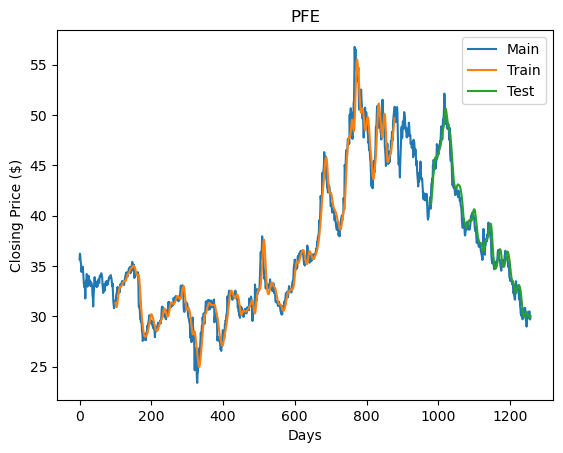

In [18]:
#Plotting Time!!!!!!
look_back = 100

# Create empty plots for predictions
train_predictions_plot = np.full_like(df2, fill_value=np.nan)
test_predictions_plot = np.full_like(df2, fill_value=np.nan)

# Fill in the training prediction plot
train_prediction_end = look_back + len(train_predict)
train_predictions_plot[look_back:train_prediction_end, :] = train_predict

# Calculate the start and end indices for test prediction plot
test_prediction_start = len(train_predict) + (look_back * 2) + 1
test_prediction_end = len(df2) - 1

# Fill in the test prediction plot
test_predictions_plot[test_prediction_start:test_prediction_end, :] = test_predict

# Plot the results
plt.plot(scaler.inverse_transform(df2), label="Main")
plt.plot(train_predictions_plot, label="Train")
plt.plot(test_predictions_plot, label="Test")

#(WB)naming the graph
plt.title(graph_label)
# Add labels for x and y axis - SK
plt.xlabel('Days')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.show()

# Predict the future 30 days and plot the output

In [19]:
# Extracting the last 100 data points from the test data and reshaping it for prediction
x_input = test_data[len(test_data)-100 : ].reshape(1, -1)
x_input.shape

(1, 100)

In [20]:
# Converting the reshaped input to a list
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
temp_input

[0.35248094715200606,
 0.3516033531091245,
 0.3536511869019143,
 0.36125711629962365,
 0.34780033123056886,
 0.3589168655186046,
 0.36476749247114926,
 0.3744213700210475,
 0.3928514167185664,
 0.39606914718306485,
 0.3829050078210401,
 0.38729297803544704,
 0.3695450851645894,
 0.3656997503076851,
 0.36540401689682844,
 0.35209304006398745,
 0.3444022559907738,
 0.3340492994228743,
 0.33464088060398334,
 0.35416363137756735,
 0.3529803546559471,
 0.35889639518583616,
 0.3553467937397825,
 0.36481232135632036,
 0.3656997503076851,
 0.34558541835299206,
 0.348247590847681,
 0.37871476501087176,
 0.38315179540828725,
 0.39350475197618673,
 0.3884761403976653,
 0.38315179540828725,
 0.36836192280237134,
 0.3748695445133665,
 0.36984081857544293,
 0.3680661893915176,
 0.36067113872916057,
 0.3452896849421385,
 0.3571215372831098,
 0.3452896849421385,
 0.31541397760065193,
 0.3127518051059628,
 0.3118644905140031,
 0.302694696308319,
 0.3089064702490587,
 0.3068358789354788,
 0.308906470249

In [21]:
# using "sliding window technique" for forecasting 

forecast_steps = 30  
lst_output = []     
window_size = 100    
current_step = 0     

# make a loop for generating predictions for the next 'forecast_steps' time steps
while current_step < forecast_steps:
    
    if len(temp_input) > window_size:
        
        current_input = np.array(temp_input[-window_size:]) 
        print(f"Step {current_step + 1} - Input: {current_input}")
        current_input = current_input.reshape(1, -1)
        current_input = current_input.reshape((1, window_size, 1))
        
        # Generate predictions using the model
        predictions = model.predict(current_input, verbose=0)
        print(f"Step {current_step + 1} - Output: {predictions}")
       
        temp_input.extend(predictions[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(predictions.tolist())
        current_step += 1

    # Prepare input data for prediction when 'temp_input' has less than or equal to 'window_size' elements
    else:
        current_input = np.array(temp_input)  
        current_input = current_input.reshape((1, len(temp_input), 1))
       
        # Generate predictions using the model
        predictions = model.predict(current_input, verbose=0)

        temp_input.extend(predictions[0].tolist())
        lst_output.extend(predictions.tolist())
        current_step += 1


Step 2 - Input: [0.35160335 0.35365119 0.36125712 0.34780033 0.35891687 0.36476749
 0.37442137 0.39285142 0.39606915 0.38290501 0.38729298 0.36954509
 0.36569975 0.36540402 0.35209304 0.34440226 0.3340493  0.33464088
 0.35416363 0.35298035 0.3588964  0.35534679 0.36481232 0.36569975
 0.34558542 0.34824759 0.37871477 0.3831518  0.39350475 0.38847614
 0.3831518  0.36836192 0.37486954 0.36984082 0.36806619 0.36067114
 0.34528968 0.35712154 0.34528968 0.31541398 0.31275181 0.31186449
 0.3026947  0.30890647 0.30683588 0.30890647 0.30654003 0.29382075
 0.30417371 0.29322917 0.27045266 0.2657199  0.274298   0.2571418
 0.2482678  0.24797201 0.27991819 0.3026947  0.30151153 0.28405949
 0.28879225 0.27873503 0.28080562 0.27991819 0.27814345 0.27252326
 0.24856365 0.28287621 0.26749476 0.22785773 0.22135017 0.20537708
 0.21099727 0.19886951 0.20774346 0.2204628  0.18940398 0.20241906
 0.20271485 0.20123589 0.2009401  0.22342076 0.22105438 0.22312497
 0.21040563 0.18852124 0.18252549 0.16753618 0.

In [22]:
# Generating an array representing the days for the last 100 days of available stock data
day_new = np.arange(1, 101)

# Generating an array representing the next 30 days for which price predictions are being made
day_pred = np.arange(101, 131)

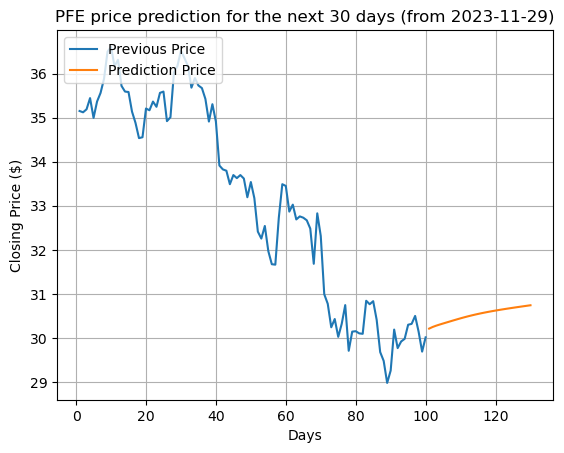

In [23]:
# Plotting the historical stock prices (last 100 days) from the dataset 'df2'
plt.plot(day_new, scaler.inverse_transform(df2[len(df2)-100:]), label="Previous Price")

# Plotting the predicted stock prices for the next 30 days ('lst_output')
plt.plot(day_pred, scaler.inverse_transform(lst_output), label="Prediction Price")
plt.legend(loc="upper left")

#(WB)graph now labels automatically using the input from the 2nd cell
plt.title(graph_label + " price prediction for the next 30 days (from 2023-11-29)")

# Add labels for x and y axis - SK
plt.xlabel('Days')
plt.ylabel('Closing Price ($)')
plt.grid()
plt.show()

# OPTIMIZING THE MODEL 

Changes Implemented in the Optimized Model (Third Iteration):
- Increase the number of LSTM units in each layer to 70
- Increase the number of epochs to 100

By making these adjustments, we were able to achieve an r-squared of at least 0.8 for both the training and testing data across the 10 healthcare stocks under analysis.

# Create a Stacked LSTM Model

In [24]:
model = Sequential()

# Increase the number of LSTM units in each layer to 70

# First hidden layer
model.add(LSTM(70, return_sequences=True, input_shape=(100, 1)))

# Second hidden layer
model.add(LSTM(70, return_sequences=True))

# Third hidden layer
model.add(LSTM(70))

# Output layer
model.add(Dense(1))

# Check the structure of the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 100, 70)           20160     
                                                                 
 lstm_4 (LSTM)               (None, 100, 70)           39480     
                                                                 
 lstm_5 (LSTM)               (None, 70)                39480     
                                                                 
 dense_1 (Dense)             (None, 1)                 71        
                                                                 
Total params: 99191 (387.46 KB)
Trainable params: 99191 (387.46 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [25]:
# Compile the model
model.compile(loss="mean_squared_error", optimizer="adam")

In [26]:
# Train the model
# Increase the number of epochs to 100
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=100, batch_size=64, verbose=1)

Epoch 1/100
13/13 [==============================] - 4s 165ms/step - loss: 0.0503 - val_loss: 0.0211
Epoch 2/100
13/13 [==============================] - 2s 132ms/step - loss: 0.0099 - val_loss: 0.0040
Epoch 3/100
13/13 [==============================] - 2s 130ms/step - loss: 0.0045 - val_loss: 0.0026
Epoch 4/100
13/13 [==============================] - 2s 132ms/step - loss: 0.0034 - val_loss: 0.0027
Epoch 5/100
13/13 [==============================] - 2s 133ms/step - loss: 0.0032 - val_loss: 0.0029
Epoch 6/100
13/13 [==============================] - 2s 132ms/step - loss: 0.0031 - val_loss: 0.0028
Epoch 7/100
13/13 [==============================] - 2s 130ms/step - loss: 0.0029 - val_loss: 0.0020
Epoch 8/100
13/13 [==============================] - 2s 130ms/step - loss: 0.0026 - val_loss: 0.0018
Epoch 9/100
13/13 [==============================] - 2s 133ms/step - loss: 0.0025 - val_loss: 0.0016
Epoch 10/100
13/13 [==============================] - 2s 133ms/step - loss: 0.0024 - val_lo

# Make Predictions and Evaluate the Model

In [27]:
# Make predictions for 'Close' prices on training and testing data
train_predict = model.predict(X_train)
test_predict = model.predict(X_test)

9/9 [==============================] - 0s 20ms/step


In [28]:
# Evaluate the model and calculate r-squared for performance metrics - AA

# Evaluate training data - AA
r_squared_train = r2_score(y_train, train_predict)
print(f"Train Data R-squared: {r_squared_train}")

# Evaluate testing data - AA
r_squared_test = r2_score(y_test, test_predict)
print(f"Test Data R-squared: {r_squared_test}")

Train Data R-squared: 0.9904849795742121
Test Data R-squared: 0.9866919718542458


# Plot the Output

In [29]:
# Transform to original form
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

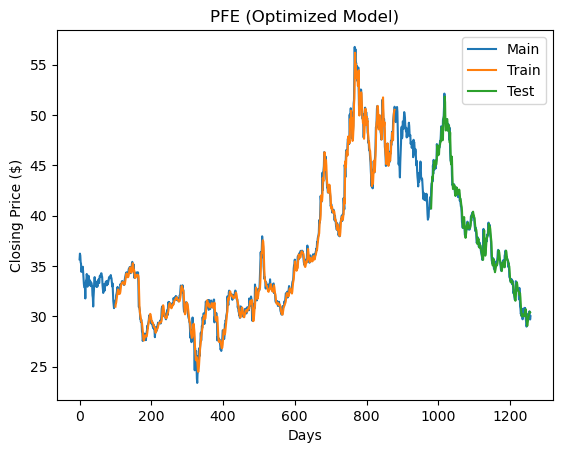

In [30]:
# Plotting
look_back_window = 100

# Initialize an empty plot for training predictions
train_predict_plot = np.empty_like(df2)
train_predict_plot[:, :] = np.nan

# Fill in the training prediction plot
train_start_index = look_back_window
train_end_index = train_start_index + len(train_predict)
train_predict_plot[train_start_index:train_end_index, :] = train_predict

# Initialize an empty plot for test predictions
test_predict_plot = np.empty_like(df2)
test_predict_plot[:, :] = np.nan

# Calculate the start and end indices for test prediction plot
test_start_index = len(train_predict) + (look_back_window * 2) + 1
test_end_index = len(df2) - 1

# Fill in the test prediction plot
test_predict_plot[test_start_index:test_end_index, :] = test_predict

# Plot Baseline and Prediction
plt.plot(scaler.inverse_transform(df2), label="Main")
plt.plot(train_predict_plot, label="Train")
plt.plot(test_predict_plot, label="Test")

# Add title and axes labels
plt.title(graph_label + " (Optimized Model)")
plt.xlabel('Days')
plt.ylabel('Closing Price ($)')
plt.legend()
plt.show()


# Predict the future 30 days and plot the output

In [31]:
# Extracting the last 100 data points from the test data and reshaping it for prediction
x_input = test_data[len(test_data)-100 : ].reshape(1, -1)
x_input.shape

(1, 100)

In [32]:
# Converting the reshaped input to a list
temp_input = list(x_input)
temp_input = temp_input[0].tolist()
temp_input

[0.35248094715200606,
 0.3516033531091245,
 0.3536511869019143,
 0.36125711629962365,
 0.34780033123056886,
 0.3589168655186046,
 0.36476749247114926,
 0.3744213700210475,
 0.3928514167185664,
 0.39606914718306485,
 0.3829050078210401,
 0.38729297803544704,
 0.3695450851645894,
 0.3656997503076851,
 0.36540401689682844,
 0.35209304006398745,
 0.3444022559907738,
 0.3340492994228743,
 0.33464088060398334,
 0.35416363137756735,
 0.3529803546559471,
 0.35889639518583616,
 0.3553467937397825,
 0.36481232135632036,
 0.3656997503076851,
 0.34558541835299206,
 0.348247590847681,
 0.37871476501087176,
 0.38315179540828725,
 0.39350475197618673,
 0.3884761403976653,
 0.38315179540828725,
 0.36836192280237134,
 0.3748695445133665,
 0.36984081857544293,
 0.3680661893915176,
 0.36067113872916057,
 0.3452896849421385,
 0.3571215372831098,
 0.3452896849421385,
 0.31541397760065193,
 0.3127518051059628,
 0.3118644905140031,
 0.302694696308319,
 0.3089064702490587,
 0.3068358789354788,
 0.308906470249

In [33]:
#doing Time series Forcasting like before
#re-defining the current_step to reset the loop to reset the loop
current_step = 0  
while current_step < forecast_steps:

    if len(temp_input) > window_size:
         # Prepare input data for prediction if 'temp_input' has more than 'window_size' elements
        current_input = np.array(temp_input[1:])
        print(f"Step {current_step + 1} - Input: {current_input}")
        current_input = current_input.reshape(1, -1)
        current_input = current_input.reshape((1, window_size, 1))
        #make predictions
        predictions = model.predict(current_input, verbose=0)
        print(f"Step {current_step + 1} - Output: {predictions}")
        #Update 'temp_input' and 'lst_output' with the predicted values
        temp_input.extend(predictions[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(predictions.tolist())
        current_step += 1

    else:
         # Prepare input data for prediction when 'temp_input' has less than or equal to 'window_size' elements
        current_input = current_input.reshape((1, window_size, 1))
        # Generate predictions using the model
        predictions = model.predict(current_input, verbose=0)
        print(predictions[0])
        temp_input.extend(predictions[0].tolist())
        print(len(temp_input))
        lst_output.extend(predictions.tolist())
        current_step += 1

[0.21772131]
101
Step 2 - Input: [0.35160335 0.35365119 0.36125712 0.34780033 0.35891687 0.36476749
 0.37442137 0.39285142 0.39606915 0.38290501 0.38729298 0.36954509
 0.36569975 0.36540402 0.35209304 0.34440226 0.3340493  0.33464088
 0.35416363 0.35298035 0.3588964  0.35534679 0.36481232 0.36569975
 0.34558542 0.34824759 0.37871477 0.3831518  0.39350475 0.38847614
 0.3831518  0.36836192 0.37486954 0.36984082 0.36806619 0.36067114
 0.34528968 0.35712154 0.34528968 0.31541398 0.31275181 0.31186449
 0.3026947  0.30890647 0.30683588 0.30890647 0.30654003 0.29382075
 0.30417371 0.29322917 0.27045266 0.2657199  0.274298   0.2571418
 0.2482678  0.24797201 0.27991819 0.3026947  0.30151153 0.28405949
 0.28879225 0.27873503 0.28080562 0.27991819 0.27814345 0.27252326
 0.24856365 0.28287621 0.26749476 0.22785773 0.22135017 0.20537708
 0.21099727 0.19886951 0.20774346 0.2204628  0.18940398 0.20241906
 0.20271485 0.20123589 0.2009401  0.22342076 0.22105438 0.22312497
 0.21040563 0.18852124 0.18252

In [34]:
# Generating an array representing the days for the last 100 days of available stock data
day_new = np.arange(1, 101)

# Generating an array representing the next 30 days for which price predictions are being made
day_pred = np.arange(101, 131)

In [35]:
# Doing Time series Forecasting like before
# using "sliding window technique" for forecasting 

forecast_steps = 30  
lst_output = []     
window_size = 100    
current_step = 0     

# make a loop for generating predictions for the next 'forecast_steps' time steps
while current_step < forecast_steps:
    
    if len(temp_input) > window_size:
        
        current_input = np.array(temp_input[-window_size:]) 
        print(f"Step {current_step + 1} - Input: {current_input}")
        current_input = current_input.reshape(1, -1)
        current_input = current_input.reshape((1, window_size, 1))
        
        # Generate predictions using the model
        predictions = model.predict(current_input, verbose=0)
        print(f"Step {current_step + 1} - Output: {predictions}")
       
        temp_input.extend(predictions[0].tolist())
        temp_input = temp_input[1:]
        lst_output.extend(predictions.tolist())
        current_step += 1

    # Prepare input data for prediction when 'temp_input' has less than or equal to 'window_size' elements
    else:
        current_input = np.array(temp_input)  
        current_input = current_input.reshape((1, len(temp_input), 1))
       
        # Generate predictions using the model
        predictions = model.predict(current_input, verbose=0)

        temp_input.extend(predictions[0].tolist())
        lst_output.extend(predictions.tolist())
        current_step += 1


Step 1 - Input: [0.38847614 0.3831518  0.36836192 0.37486954 0.36984082 0.36806619
 0.36067114 0.34528968 0.35712154 0.34528968 0.31541398 0.31275181
 0.31186449 0.3026947  0.30890647 0.30683588 0.30890647 0.30654003
 0.29382075 0.30417371 0.29322917 0.27045266 0.2657199  0.274298
 0.2571418  0.2482678  0.24797201 0.27991819 0.3026947  0.30151153
 0.28405949 0.28879225 0.27873503 0.28080562 0.27991819 0.27814345
 0.27252326 0.24856365 0.28287621 0.26749476 0.22785773 0.22135017
 0.20537708 0.21099727 0.19886951 0.20774346 0.2204628  0.18940398
 0.20241906 0.20271485 0.20123589 0.2009401  0.22342076 0.22105438
 0.22312497 0.21040563 0.18852124 0.18252549 0.16753618 0.17593022
 0.20381035 0.19121933 0.19571611 0.19751481 0.20710796 0.20770755
 0.21310371 0.20231139 0.18882104 0.19853707 0.21772131 0.20017347
 0.20254046 0.20334363 0.20350462 0.20350824 0.20348732 0.20344326
 0.20335135 0.20319092 0.20294994 0.20262344 0.20221241 0.20172228
 0.20116168 0.20054115 0.19987221 0.19916603 0.1

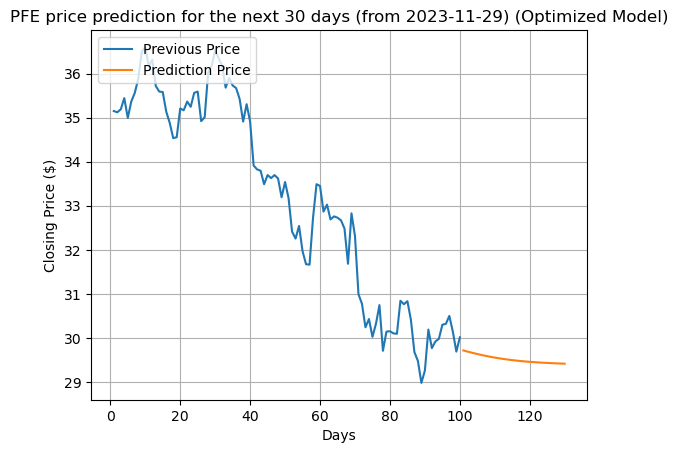

In [36]:
# Plotting the historical stock prices (last 100 days) from the dataset 'df2'
plt.plot(day_new, scaler.inverse_transform(df2[len(df2)-100:]), label="Previous Price")

# Plotting the predicted stock prices for the next 30 days ('lst_output')
plt.plot(day_pred, scaler.inverse_transform(lst_output), label="Prediction Price")
plt.legend(loc="upper left")

#(WB)graph now labels automatically using the input from the 2nd cell
plt.title(graph_label + " price prediction for the next 30 days (from 2023-11-29) (Optimized Model)")

# Add labels for x and y axis - SK
plt.xlabel('Days')
plt.ylabel('Closing Price ($)')
plt.grid()
plt.show()

In [37]:
print("Optimized Model Performance Metrics:")
print("------------------------------------")

print(f"Train Data R-squared: {r_squared_train}")

print(f"Test Data R-squared: {r_squared_test}")

Optimized Model Performance Metrics:
------------------------------------
Train Data R-squared: 0.9904849795742121
Test Data R-squared: 0.9866919718542458
